<style>
    h3{
        color:red;
    }

### Nối ảnh - image stiching
Nối ảnh là phương pháp đơn giản nhất để tạo được một bức ảnh toàn cảnh mà không cần ống kích góc rộng hoặc siêu rộng khi chụp ảnh.

Nối ảnh chỉ đơn giản là ghép các ảnh lại với nhau nhờ các phần trùng lắp giữa ảnh này với ảnh kia sao cho kết quả liền lạc





### Nối ảnh - Image Stitching
Nối ảnh là phương pháp ghép nhiều ảnh nhỏ lại với nhau để tạo được ảnh toàn cảnh - hay thường được gọi là ảnh panorama. 

Đầu vào của thuật toán là nhiều ảnh được sắp theo thứ tự và ảnh này phải chứa một phần của ảnh kia (gọi là vùng trùng lắp) để làm cơ sở để ghép chúng vào nhau.

Có rất nhiều phương pháp để ghép ảnh với nhau:
- Image Stitching Based on Region
- Image Stitching Based on Ratio Matching
- Image Stitching Based on Line and Plane Feature
- Image Stitching Based on FFT
- Image Stitching Based on Feature Points
- ...

Ghép 2 ảnh dựa vào Feature Point bằng thuật toán SIFT theo các bước sau đây:
1. Tính Key point và descriptor (Đặc tả) bằng thuật toán SIFT của 2 ảnh, đây là cơ sở để ghép chúng với nhau
2. Tính khoảng cách giữa 2 descriptor (Đặc tả)
3. Chọn các điểm trùng khớp giữa 2 ảnh
4. Chạy RANSAC để ước tính sự đồng nhất
5. Căn chỉnh ảnh trước khi ghép lại
6. Ghép chúng với nhau

Sau đây là mã nguồn từ slide của thầy và từ trang web
https://pylessons.com/OpenCV-image-stiching

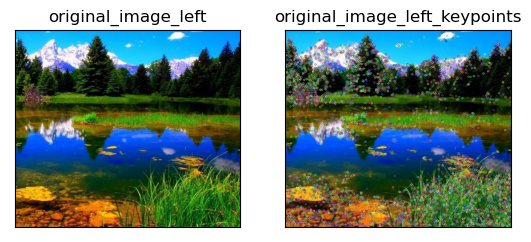

In [2]:
# Khai báo các thư viện và hàm hỗ trợ hiển thị
import cv2
import numpy as np
from matplotlib import pyplot as plt

def Show(pos, image, name, gray=False, hideTisks=False):
    plt.subplot(pos)
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    if hideTisks:
        plt.xticks([]), plt.yticks([])

# Đọc 2 ảnh vào
img_ = cv2.imread('Data/original_image_right.jpg')
#img_ = cv2.imread('original_image_left.jpg')
#img_ = cv2.resize(img_, (0,0), fx=1, fy=1)
img1 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)

img = cv2.imread('Data/original_image_left.jpg')
#img = cv2.imread('original_image_right.jpg')
#img = cv2.resize(img, (0,0), fx=1, fy=1)
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. Tính Key point và descriptor (Đặc tả) bằng thuật toán SIFT 
# của 2 ảnh, đây là cơ sở để ghép chúng với nhau
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

#cv2.imshow('original_image_left_keypoints',cv2.drawKeypoints(img_,kp1,None))
Show(121, img_, 'original_image_left', False, True)
Show(122, cv2.drawKeypoints(img_, kp1, None), 'original_image_left_keypoints', False, True)
plt.show()

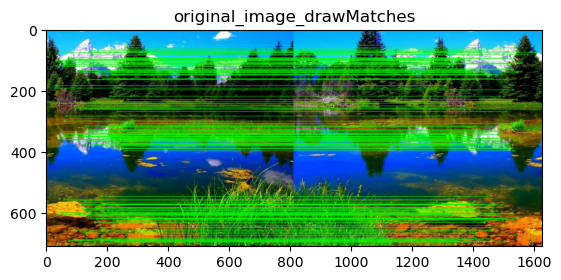

In [5]:
# 2. Tính khoảng cách giữa 2 descriptor (Đặc tả)

#FLANN_INDEX_KDTREE = 0
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks = 50)
#match = cv2.FlannBasedMatcher(index_params, search_params)
match = cv2.BFMatcher()
matches = match.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.03*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, flags=2)

img3 = cv2.drawMatches(img_, kp1, img, kp2, good, None, **draw_params)
#cv2.imshow("original_image_drawMatches.jpg", img3)
Show(111, img3, "original_image_drawMatches")
plt.show()
# Phần in ảnh bị sai (Nếu thay ảnh trái thành ảnh phải thì lại đúng)


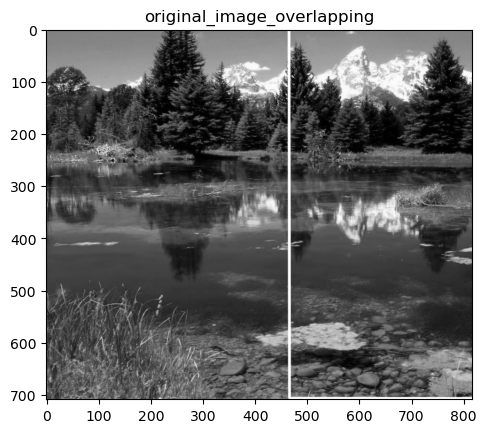

In [97]:
# 4. Chạy RANSAC để ước tính sự đồng nhất

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    #cv2.imshow("original_image_overlapping.jpg", img2)
    Show(111, img2, "original_image_overlapping")
    plt.show()
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

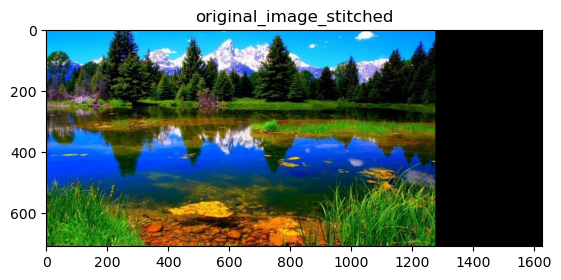

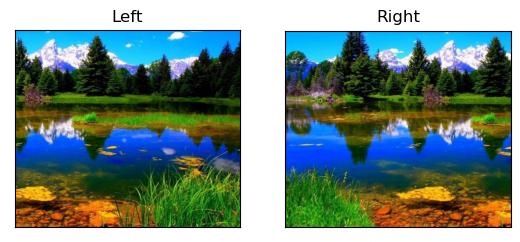

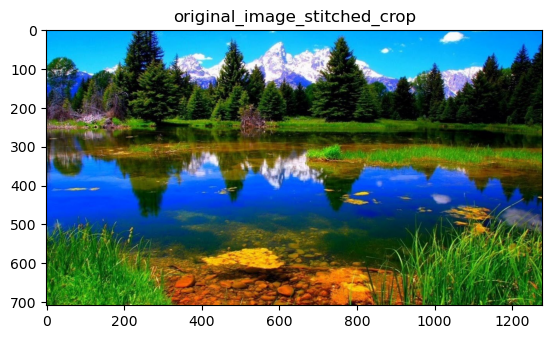

In [98]:
# 5. Căn chỉnh ảnh trước khi ghép lại
dst = cv2.warpPerspective(    img_, M, (img.shape[1] + img_.shape[1], img.shape[0]))
# 6. Ghép chúng với nhau
dst[0:img.shape[0], 0:img.shape[1]] = img
# cv2.imshow("original_image_stitched.jpg", dst)
Show(111, dst, "original_image_stitched")
plt.show()
# Cắt bớt phần dư
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:, 0]):
        return trim(frame[:, 1:])
    #crop top
    if not np.sum(frame[:, -1]):
        return trim(frame[:, :-2])
    return frame
# Hiển thị
Show(121, img_, 'Left', False, True)
Show(122, img, 'Right', False, True)
plt.show()
Show(111, trim(dst), "original_image_stitched_crop")
plt.show()
#cv2.imshow("original_image_stitched_crop.jpg", trim(dst))
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))
